# Section 5.2 — Bayesian inference computations

This notebook contains the code examples from [Section 5.2 Bayesian inference computations]() from the **No Bullshit Guide to Statistics**.

See also:

- [Chp_04.ipynb](./explorations/SR2024/week02/Chp_04.ipynb)
- [Chp_05.ipynb](./explorations/SR2024/week02/Chp_05.ipynb)
- [homework_week02_ivan_savov.ipynb](./explorations/SR2024/week02/homework_week02_ivan_savov.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 2)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

#######################################################

<Figure size 640x480 with 0 Axes>

In [3]:
# simple float __repr__
np.set_printoptions(legacy='1.25')

## Definitions

TODO

## Posterior inference using MCMC estimation

TODO: point-form definitions

## Bayesian inference using Bambi

TODO: mention Bambi classes

In [4]:
import bambi as bmb

In [5]:
print(bmb.Prior.__doc__)

Abstract specification of a term prior

    Parameters
    ----------
    name : str
        Name of prior distribution. Must be the name of a PyMC distribution
        (e.g., `"Normal"`, `"Bernoulli"`, etc.)
    auto_scale: bool
        Whether to adjust the parameters of the prior or use them as passed. Default to `True`.
    kwargs : dict
        Optional keywords specifying the parameters of the named distribution.
    dist : pymc.distributions.distribution.DistributionMeta or callable
        A callable that returns a valid PyMC distribution. The signature must contain `name`,
        `dims`, and `shape`, as well as its own keyworded arguments.
    


In [6]:
print("\n".join(bmb.Model.__doc__.splitlines()[0:27]))

Specification of model class

    Parameters
    ----------
    formula : str or bambi.formula.Formula
        A model description written using the formula syntax from the `formulae` library.
    data : pandas.DataFrame
        A pandas dataframe containing the data on which the model will be fit, with column
        names matching variables defined in the formula.
    family : str or bambi.families.Family
        A specification of the model family (analogous to the family object in R). Either
        a string, or an instance of class `bambi.families.Family`. If a string is passed, a
        family with the corresponding name must be defined in the defaults loaded at `Model`
        initialization. Valid pre-defined families are `"bernoulli"`, `"beta"`,
        `"binomial"`, `"categorical"`, `"gamma"`, `"gaussian"`, `"negativebinomial"`,
        `"poisson"`, `"t"`, and `"wald"`. Defaults to `"gaussian"`.
    priors : dict
        Optional specification of priors for one or more terms

## Example 1: estimating the probability of a bias of a coin

Let's revisit the biased coin example from [Section 5.1](./51_intro_to_Bayesian_stats.ipynb),
where we want to estimate the probability the coin turns up heads.

### Data

We have a sample that contains $n=50$ observations (coin tosses) from the coin.
The outcome `1` corresponds to heads,
while the outcome `0` corresponds to tails.
We package the data as the `ctoss` column of a new data frame `ctosses`.

In [7]:
ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]
ctosses = pd.DataFrame({"ctoss":ctosses})
ctosses.head(3)

,ctoss
0,1
1,1
2,0


The proportion of heads outcomes is:

In [8]:
ctosses["ctoss"].mean()

0.68

### Model

The model is

$$
    C \sim \textrm{Bernoulli}(P),
    \qquad
    P \sim \mathcal{U}(0,1).
$$

In [9]:
import bambi as bmb
bmb.Prior("Uniform", lower=0, upper=1)

Uniform(lower: 0.0, upper: 1.0)

In [10]:
priors1 = {
    "Intercept": bmb.Prior("Uniform", lower=0, upper=1)
}

mod1 = bmb.Model(formula="ctoss ~ 1",
                 family="bernoulli",
                 link="identity",
                 priors=priors1,
                 data=ctosses)
mod1.set_alias({"Intercept": "P"})
mod1

       Formula: ctoss ~ 1
        Family: bernoulli
          Link: p = identity
  Observations: 50
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Uniform(lower: 0.0, upper: 1.0)

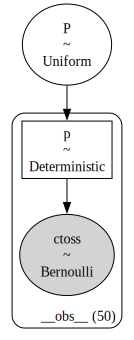

In [11]:
mod1.build()
mod1.graph()

In [12]:
# mod1.backend.model

### Fitting the model

In [13]:
idata1 = mod1.fit(random_seed=42)

Modeling the probability that ctoss==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Exploring `InferenceData` objects

In [14]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
type(idata1)

arviz.data.inference_data.InferenceData

In [16]:
idata1.groups()

['posterior', 'sample_stats', 'observed_data']

In [17]:
type(idata1["posterior"])

xarray.core.dataset.Dataset

In [18]:
list(idata1["posterior"].coords)

['chain', 'draw']

In [19]:
list(idata1["posterior"].data_vars)

['P']

In [20]:
type(idata1["posterior"]["P"])

xarray.core.dataarray.DataArray

In [21]:
idata1["posterior"]["P"]

<xarray.DataArray 'P' (chain: 4, draw: 1000)> Size: 32kB
array([[0.76122756, 0.56861221, 0.77616961, ..., 0.70772348, 0.62878475,
        0.70789234],
       [0.68937002, 0.73226925, 0.67623114, ..., 0.60182373, 0.59438488,
        0.6632119 ],
       [0.69674422, 0.67356423, 0.65844755, ..., 0.67517019, 0.67517019,
        0.64238598],
       [0.72020439, 0.75444132, 0.7699058 , ..., 0.70605793, 0.73880719,
        0.64569808]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [22]:
type(idata1["posterior"]["P"].values)

numpy.ndarray

In [23]:
idata1["posterior"]["P"].values.round(3)

array([[0.761, 0.569, 0.776, ..., 0.708, 0.629, 0.708],
       [0.689, 0.732, 0.676, ..., 0.602, 0.594, 0.663],
       [0.697, 0.674, 0.658, ..., 0.675, 0.675, 0.642],
       [0.72 , 0.754, 0.77 , ..., 0.706, 0.739, 0.646]])

In [24]:
idata1["posterior"]["P"].values.shape

(4, 1000)

### Extracting the samples from the posterior

In [25]:
postP = idata1["posterior"]["P"].values.flatten()
postP

array([0.76122756, 0.56861221, 0.77616961, ..., 0.70605793, 0.73880719,
       0.64569808])

### Visualize the posterior

#### Histogram

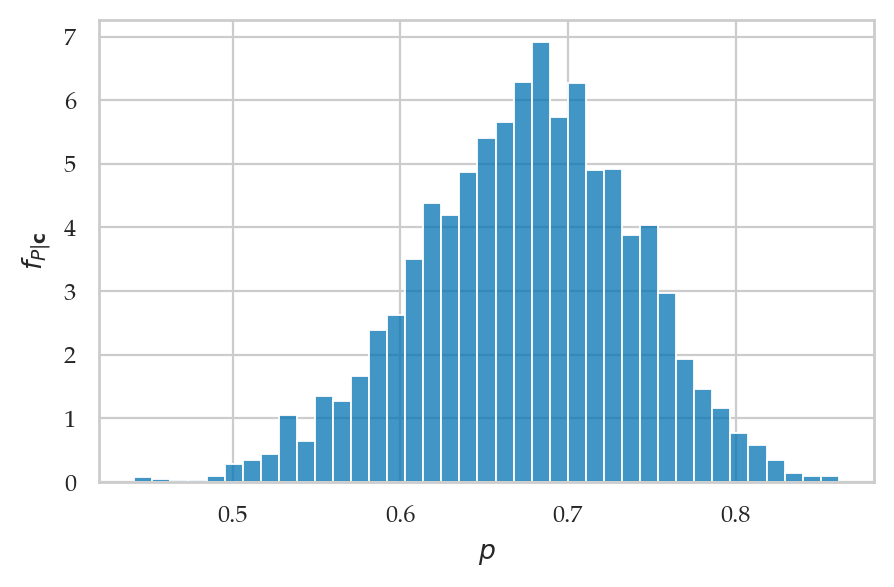

In [26]:
ax = sns.histplot(x=postP, stat="density")
ax.set_xlabel("$p$")
ax.set_ylabel("$f_{P|\\mathbf{c}}$");

#### Kernel density plot

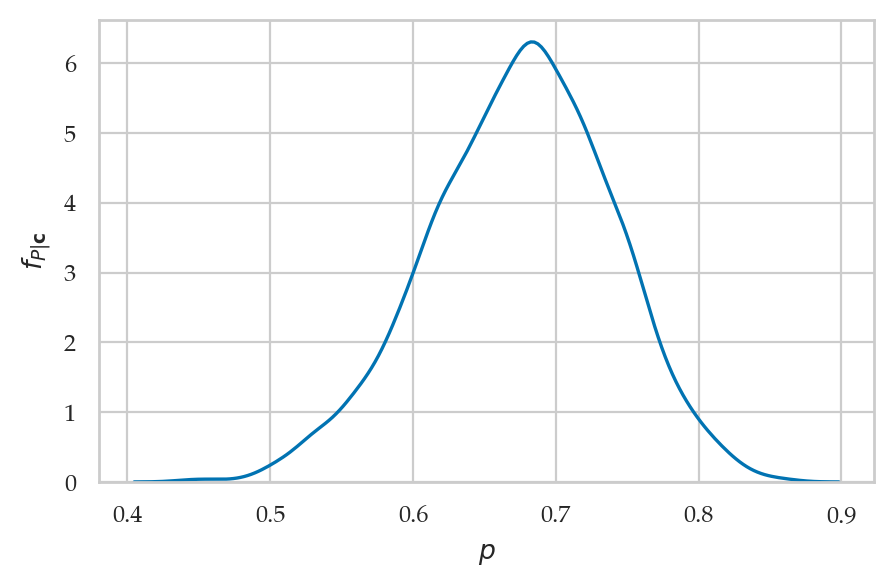

In [27]:
ax = sns.kdeplot(x=postP)
ax.set_xlabel("$p$")
ax.set_ylabel("$f_{P|\\mathbf{c}}$");

### Summarize the posterior

In [28]:
len(postP)

4000

#### Posterior mean

In [29]:
np.mean(postP)

0.6747512974497554

#### Posterior standard deviation

In [30]:
np.std(postP)

0.06413160885365309

#### Posterior median

In [31]:
np.median(postP)

0.6780571467155877

#### Posterior quartiles

In [32]:
np.quantile(postP, [0.25, 0.5, 0.75])

array([0.63207241, 0.67805715, 0.71976479])

#### Posterior percentiles

In [33]:
np.percentile(postP, [3, 97])

array([0.54664801, 0.78923245])

#### Posterior mode

In [34]:
from ministats import mode_from_samples
mode_from_samples(postP)

0.6833825973512753

### Credible interval

In [35]:
from ministats import hdi_from_samples
hdi_from_samples(postP, hdi_prob=0.9)

[0.5733806152569917, 0.7841482011374427]

## Example 2: estimating the IQ score

Let's return to the investigation of the smart drug effects on IQ scores.

### Data

We have collected data from $30$ individuals who took the smart drug,
which we have packaged into the `iq` column of the data frame `iqs`.

In [36]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]
iqs = pd.DataFrame({"iq":iqs})
iqs["iq"].mean()

107.82333333333334

### Model

We will use the following Bayesian model:

$$
    X \sim \mathcal{N}(M, \sigma=15),
    \qquad
    M \sim \mathcal{N}(\mu_M=100,\sigma_M=40).
$$

We place a broad prior on the mean parameter $M$,
by choosing a large value for the standard deviation $\sigma_M$.
We assume the IQ scores come from a population with standard deviation $\sigma = 15$.

In [37]:
import bambi as bmb

priors2 = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    "sigma": 15,
}

mod2 = bmb.Model(formula="iq ~ 1",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=iqs)

mod2.set_alias({"Intercept": "M"})
mod2

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 100.0, sigma: 40.0)
        
        Auxiliary parameters
            sigma ~ 15

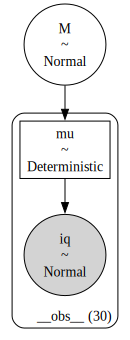

In [38]:
mod2.build()
mod2.graph()

### Fitting the model

This time we'll generate $N=2000$ samples from each chain.

In [39]:
idata2 = mod2.fit(draws=2000, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


### Extract the samples from the posterior

In [40]:
postM = idata2["posterior"]["M"].values.flatten()
len(postM)

8000

In [41]:
postM

array([111.84188777, 111.84188777, 110.69558723, ..., 105.38269922,
       106.5084091 , 107.49061702])

### Visualize the posterior

#### Histogram

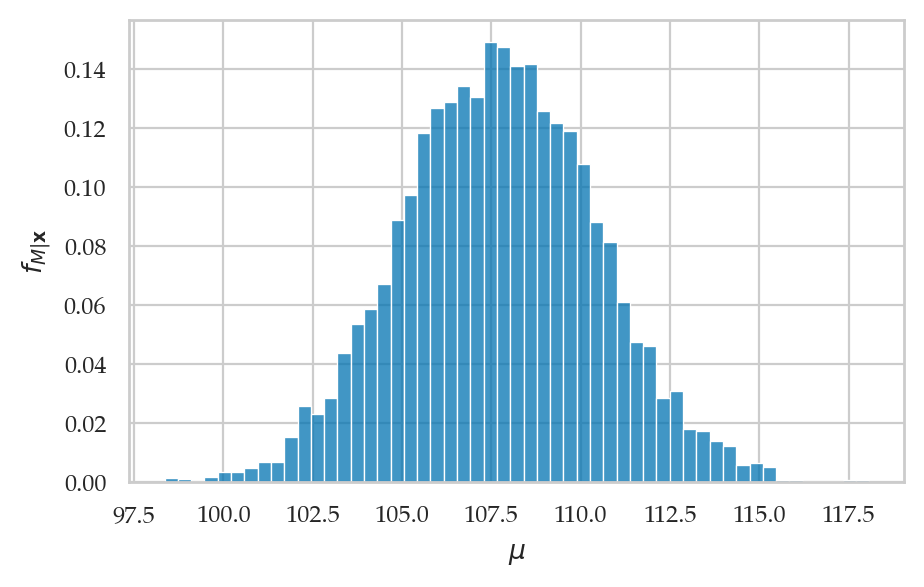

In [42]:
ax = sns.histplot(x=postM, stat="density")
ax.set_xlabel("$\\mu$")
ax.set_ylabel("$f_{M|\\mathbf{x}}$");

#### Kernel density plot

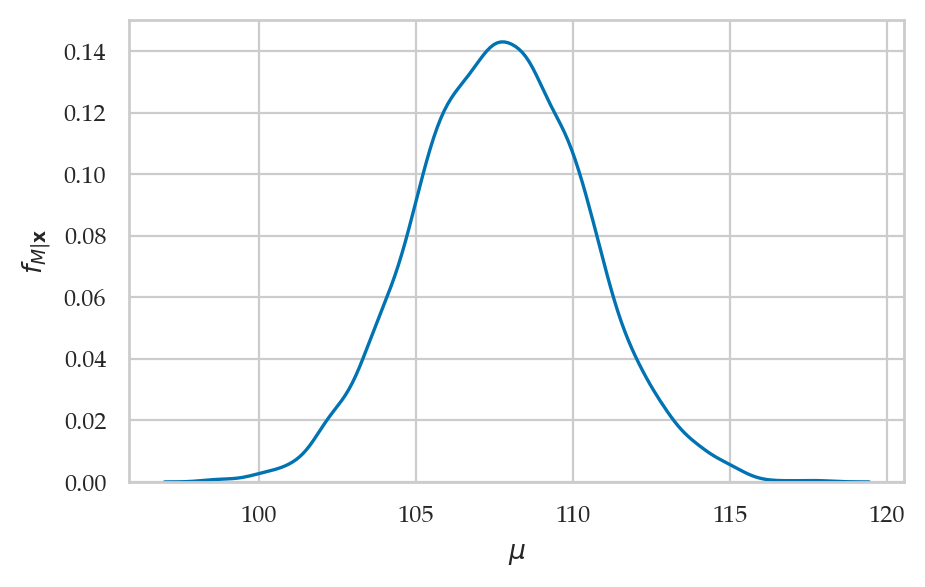

In [43]:
ax = sns.kdeplot(x=postM)
ax.set_xlabel("$\\mu$")
ax.set_ylabel("$f_{M|\\mathbf{x}}$");

### Summarize the posterior

#### Posterior mean

In [44]:
np.mean(postM)

107.72704847150636

#### Posterior standard deviation

In [45]:
np.std(postM)

2.7150176274941304

#### Posterior median

In [46]:
np.median(postM)

107.71902676335739

#### Posterior quartiles

In [47]:
np.quantile(postM, [0.25, 0.5, 0.75])

array([105.87041865, 107.71902676, 109.59653928])

#### Posterior percentiles

In [48]:
np.percentile(postM, [3, 97])

array([102.60648664, 112.88591885])

#### Posterior mode

In [49]:
from ministats import mode_from_samples
mode_from_samples(postM)

107.7582939445229

### Credible interval

In [50]:
from ministats import hdi_from_samples
hdi_from_samples(postM, hdi_prob=0.9)

[103.25275390621668, 112.12840034704796]

## Visualizing and interpreting posteriors

In [51]:
import arviz as az

### Example 1 continued: inferences about the biased coin

#### Extracting samples (CUTTABLE)

For the purpose of our data analysis,
we don't care about the `chain` and `draw` information
and are only interested in in the variable `P`,
which are the actual samples from the posterior.
The easiest way to extract the samples from the posterior
is to use the ArviZ helper method `az.extract` shown below.

In [52]:
postP = az.extract(idata1, var_names="P").values
postP.round(3)

array([0.761, 0.569, 0.776, ..., 0.706, 0.739, 0.646])

The call to the function `az.extract` selected the `posterior` group,
then selected the variable `P` within the posterior group.

/CUTTABLE

#### Summarizing the posterior

In [53]:
az.summary(idata1, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
P,0.675,0.064,0.573,0.784


#### Plotting the posterior

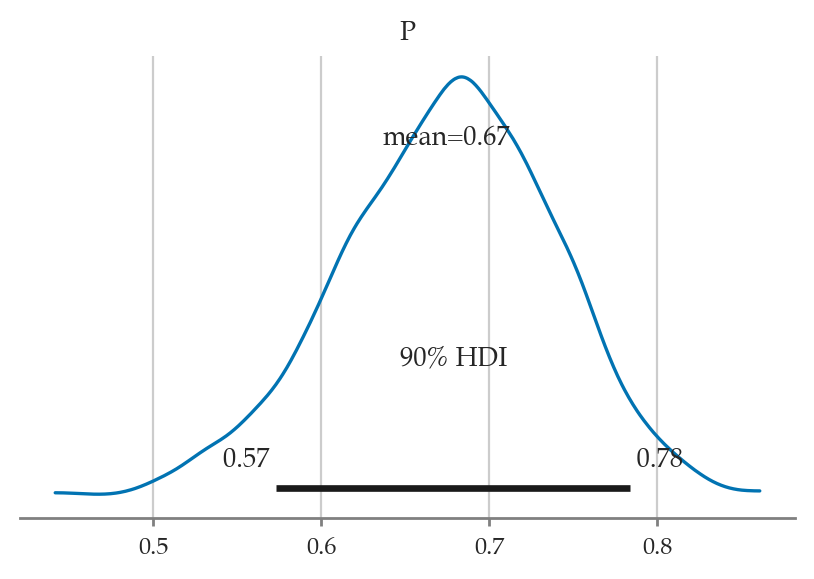

In [54]:
az.plot_posterior(idata1, var_names="P", hdi_prob=0.9);

Options:
- If multiple variables, you specify a list to `var_names` to select only certain variables to plot
- Set the option `point_estimate` to `"mode"` or `"median"`
- Add the option `rope` to draw region of practical equivalence,
  e.g., `rope=[97,103]`

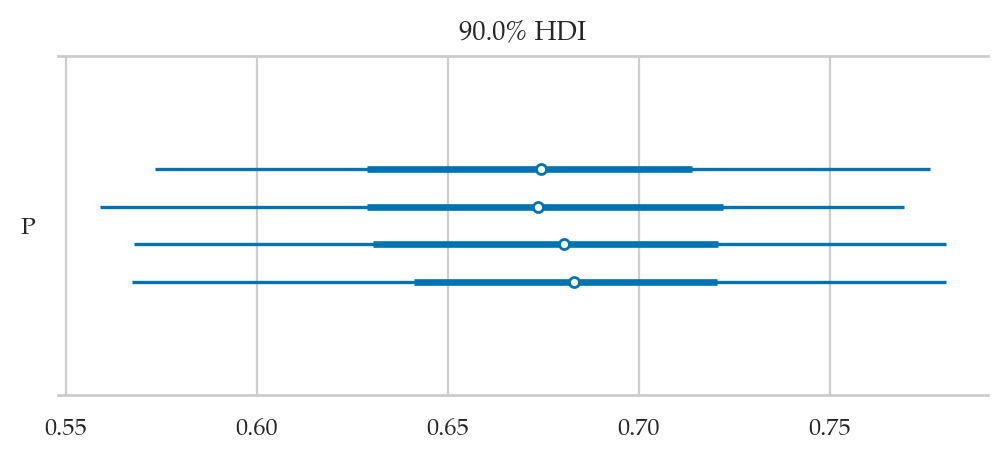

In [55]:
az.plot_forest(idata1, hdi_prob=0.9, figsize=(6,2.2));

### Example 2 continued: inferences about the population mean

#### Summarizing the posterior

In [56]:
az.summary(idata2, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
M,107.727,2.715,103.253,112.128


#### Plotting the posterior

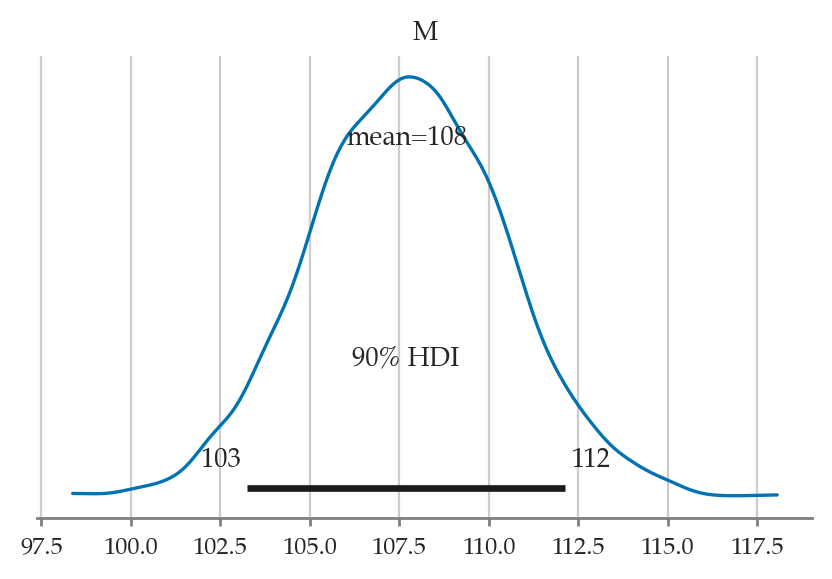

In [57]:
az.plot_posterior(idata2, var_names="M", hdi_prob=0.9);

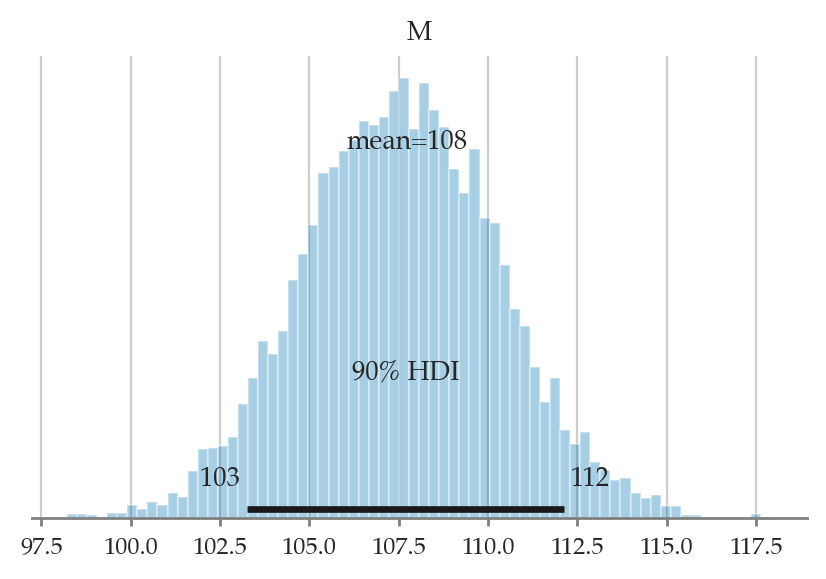

In [58]:
az.plot_posterior(idata2, var_names="M", hdi_prob=0.9, kind="hist", bins=70);

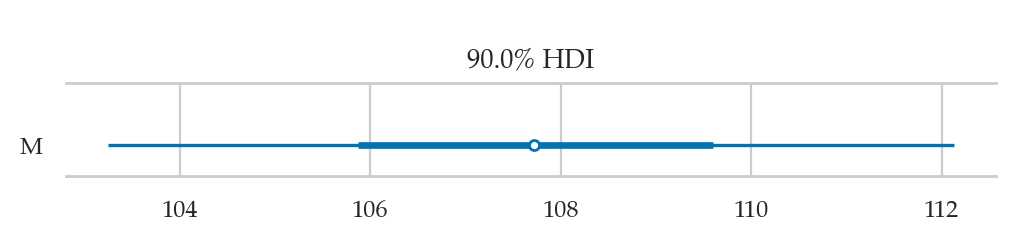

In [59]:
az.plot_forest(idata2, combined=True, hdi_prob=0.9, figsize=(6,0.6));

#### Hypothesis testing

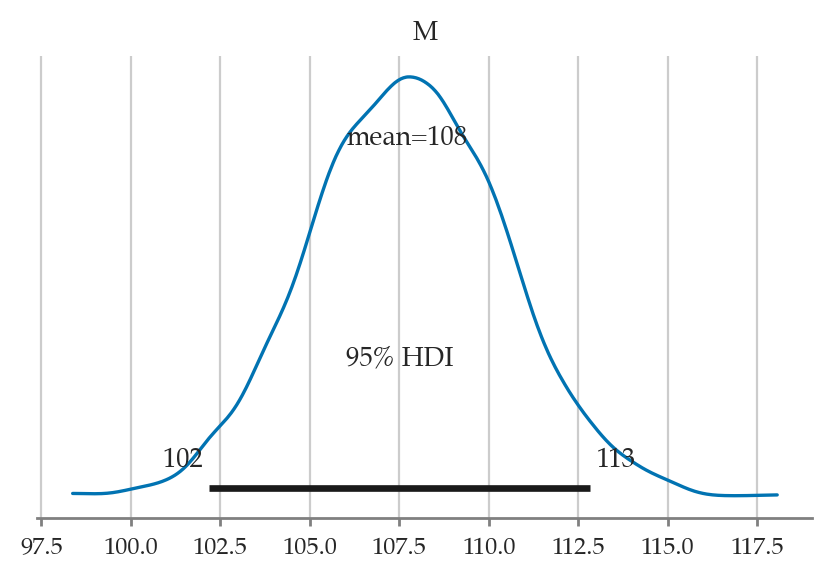

In [60]:
az.plot_posterior(idata2, hdi_prob=0.95);

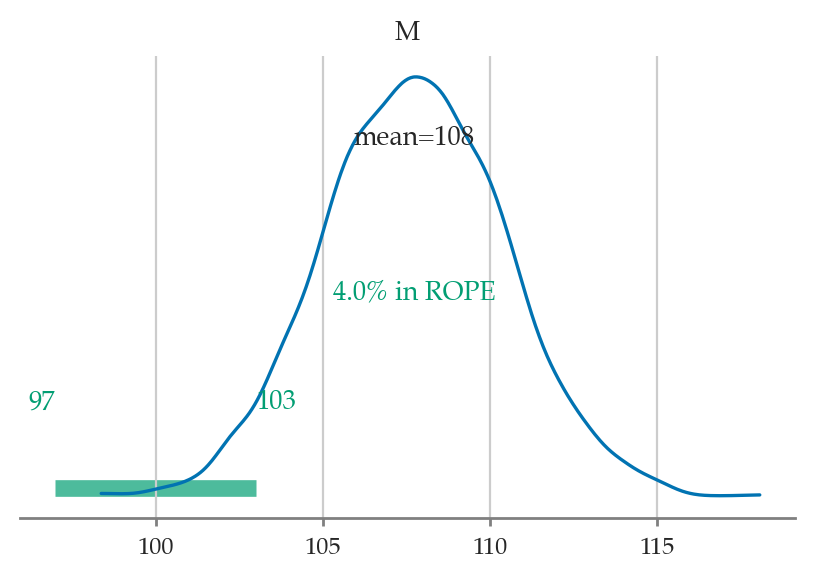

In [61]:
az.plot_posterior(idata2, hdi_prob="hide", rope=[97,103]);

## Explanations

### Visualizing prior distributions


Sampling: [M]


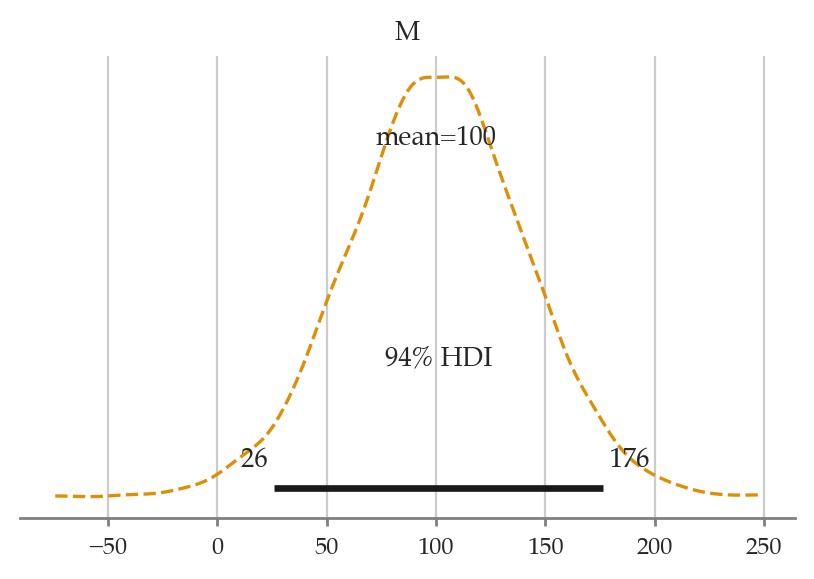

In [62]:
mod2.plot_priors(random_seed=43, color="C1", linestyle="dashed");

### Bambi default priors

In [63]:
iqs["iq"].mean(), iqs["iq"].std(ddof=0), 2.5*iqs["iq"].std(ddof=0)

(107.82333333333334, 15.812119472803834, 39.53029868200959)

In [64]:
mod2d = bmb.Model("iq ~ 1", family="gaussian", data=iqs)
mod2d

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 107.8233, sigma: 39.5303)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 15.8121)

Sampling: [Intercept, sigma]


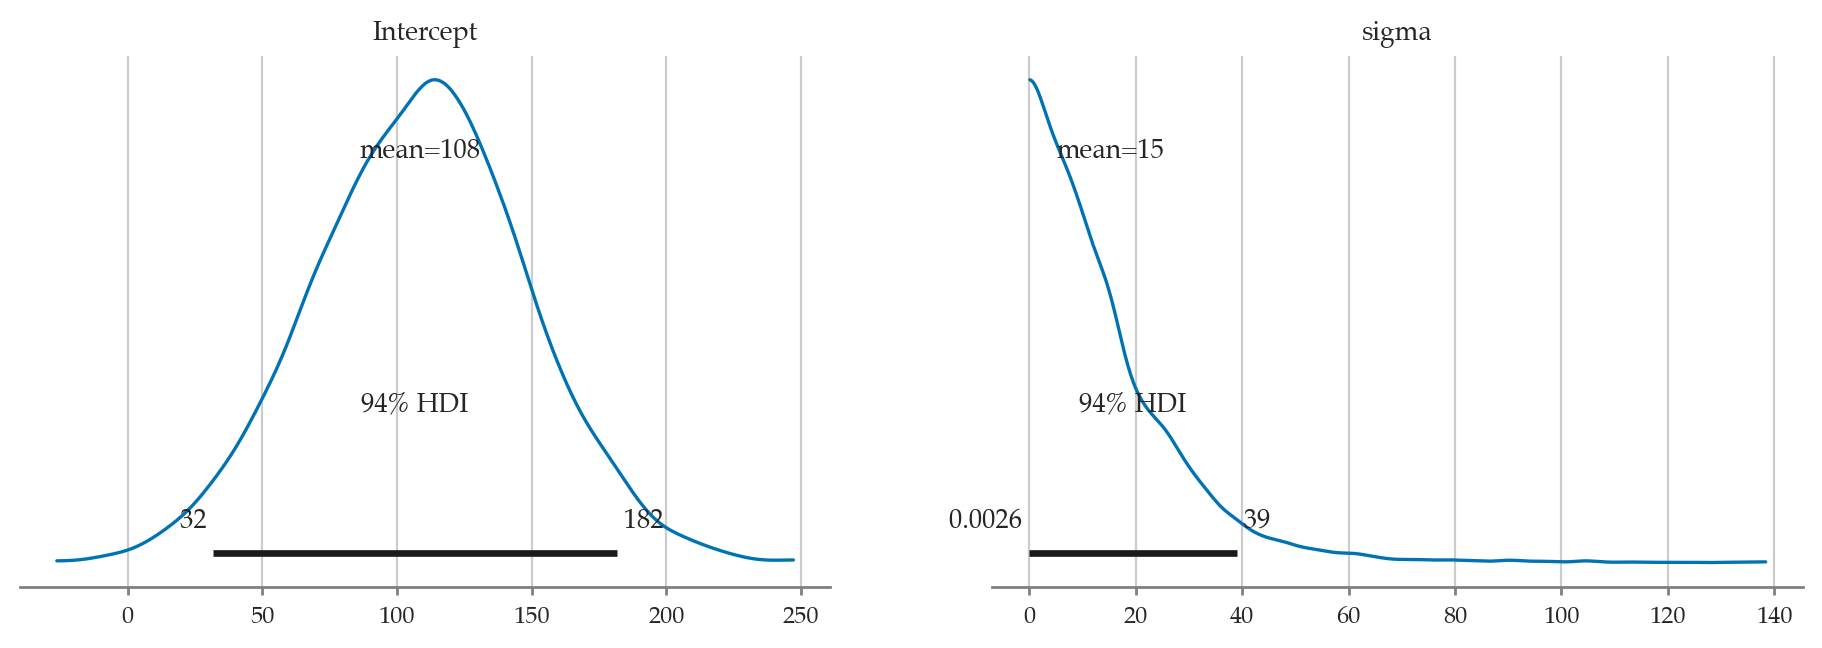

In [65]:
mod2d.build()
mod2d.plot_priors();

### More about inference data objects

In [66]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [67]:
type(idata1)

arviz.data.inference_data.InferenceData

In [68]:
idata1.groups()

['posterior', 'sample_stats', 'observed_data']

### Groups are `Dataset` objects

In [69]:
post1 = idata1["posterior"]
type(post1)

xarray.core.dataset.Dataset

In [70]:
# post1

In [71]:
post1.coords

Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [72]:
post1.data_vars

Data variables:
    P        (chain, draw) float64 32kB 0.7612 0.5686 0.7762 ... 0.7388 0.6457

### Variables are `DataArray` objects

In [73]:
Ps = post1["P"]  # == idata1["posterior"]["P"]
type(Ps)

xarray.core.dataarray.DataArray

In [74]:
# Ps

In [75]:
Ps.shape

(4, 1000)

In [76]:
Ps.name

'P'

In [77]:
Ps.to_dataframe()

P
chain draw          
0     0     0.761228
      1     0.568612
      2     0.776170
      3     0.675721
      4     0.749423
...              ...
3     995   0.767060
      996   0.743217
      997   0.706058
      998   0.738807
      999   0.645698

[4000 rows x 1 columns]

In [78]:
Ps.values

array([[0.76122756, 0.56861221, 0.77616961, ..., 0.70772348, 0.62878475,
        0.70789234],
       [0.68937002, 0.73226925, 0.67623114, ..., 0.60182373, 0.59438488,
        0.6632119 ],
       [0.69674422, 0.67356423, 0.65844755, ..., 0.67517019, 0.67517019,
        0.64238598],
       [0.72020439, 0.75444132, 0.7699058 , ..., 0.70605793, 0.73880719,
        0.64569808]])

In [79]:
Ps.values.flatten()

array([0.76122756, 0.56861221, 0.77616961, ..., 0.70605793, 0.73880719,
       0.64569808])

### MCMC diagnostics


#### Trace plots

There are several Arviz plots we can use to check if the Markov Chain Monte Carlo chains were sampling from the posterior as expected, or ...

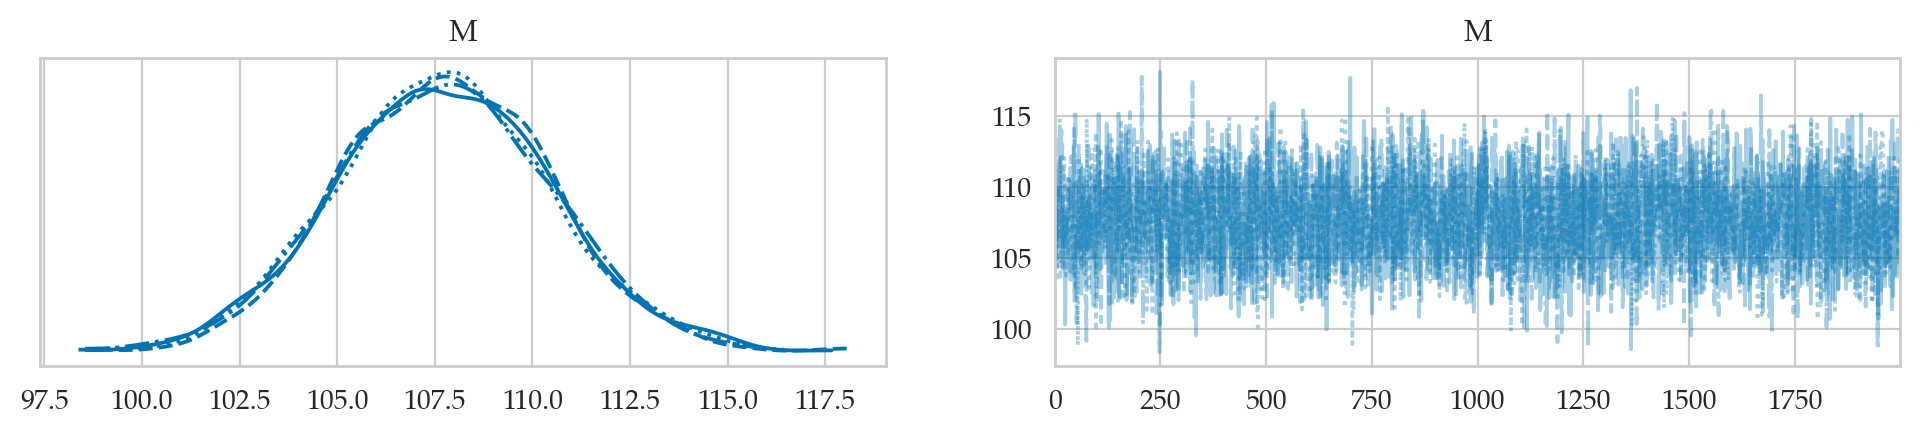

In [80]:
az.plot_trace(idata2);

#### Rank plots

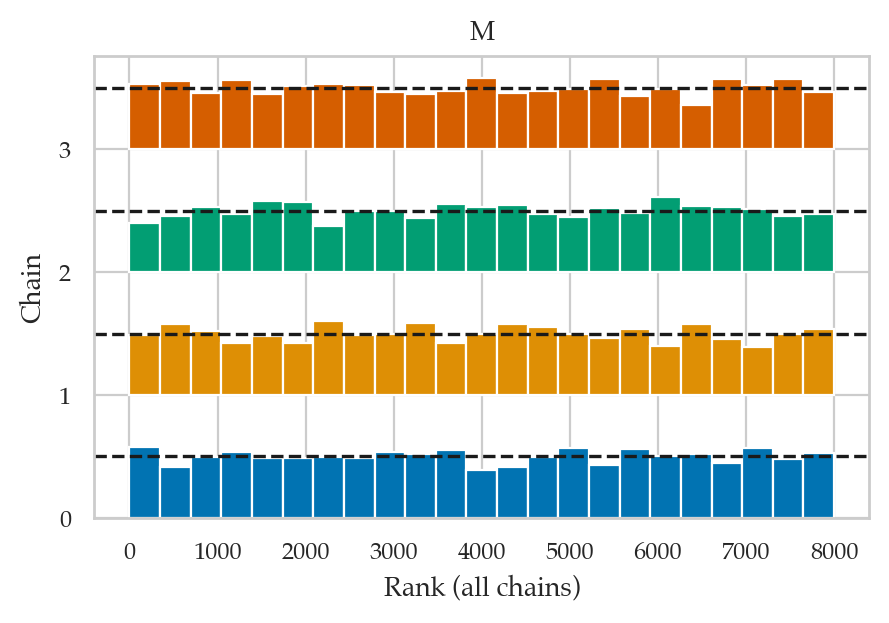

In [81]:
az.plot_rank(idata2);

#### ? Autocorrelation plot ?

https://python.arviz.org/en/stable/api/generated/arviz.plot_autocorr.html

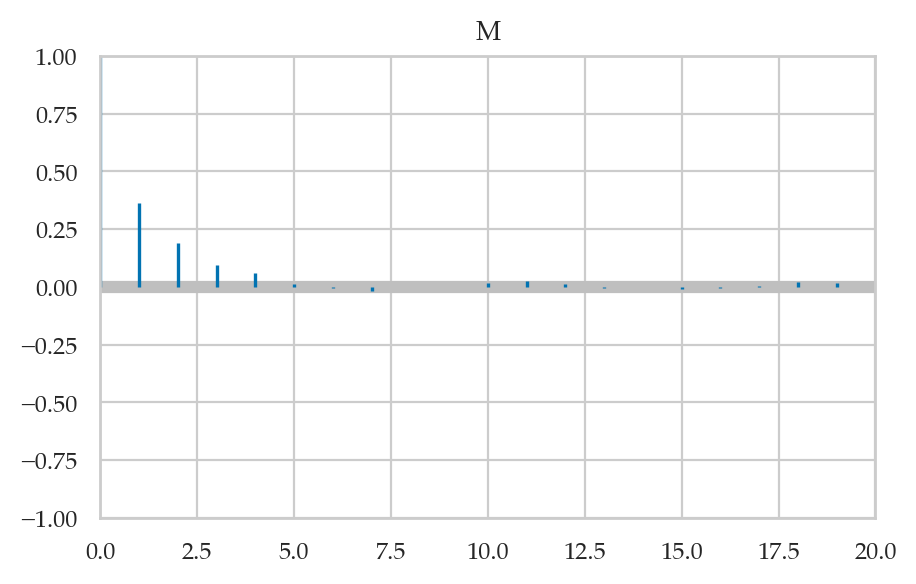

In [82]:
az.plot_autocorr(idata2, combined=True, max_lag=20);

#### Diagnostic summary

In [83]:
az.summary(idata2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
M,107.727,2.715,102.592,112.844


In [84]:
az.summary(idata2, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,0.047,0.029,3290.0,5181.0,1.0


## Bayesian workflow

See also:
- [chp_09.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_09.ipynb)
- [Section7-Bayesian_Workflow.ipynb](https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section7-Bayesian_Workflow.ipynb)

### Prior predictive checks

Sampling: [M, iq]


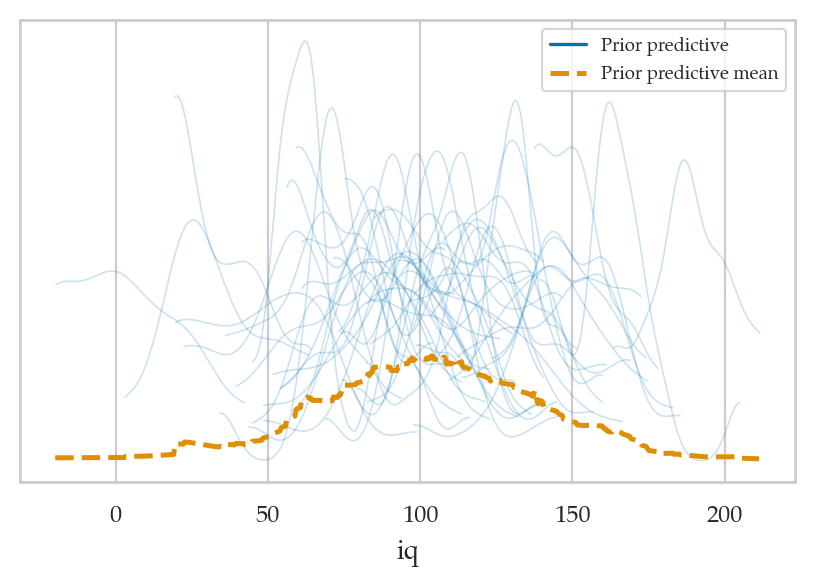

In [85]:
idata2_pri = mod2.prior_predictive(draws=50, random_seed=45)
az.plot_ppc(idata2_pri, group="prior");

In [86]:
idata2_pri['prior']["mu"].shape

(1, 50, 30)

In [87]:
idata2_pri['prior_predictive']["iq"].shape

(1, 50, 30)

### Posterior predictive checks

<Axes: xlabel='iq'>

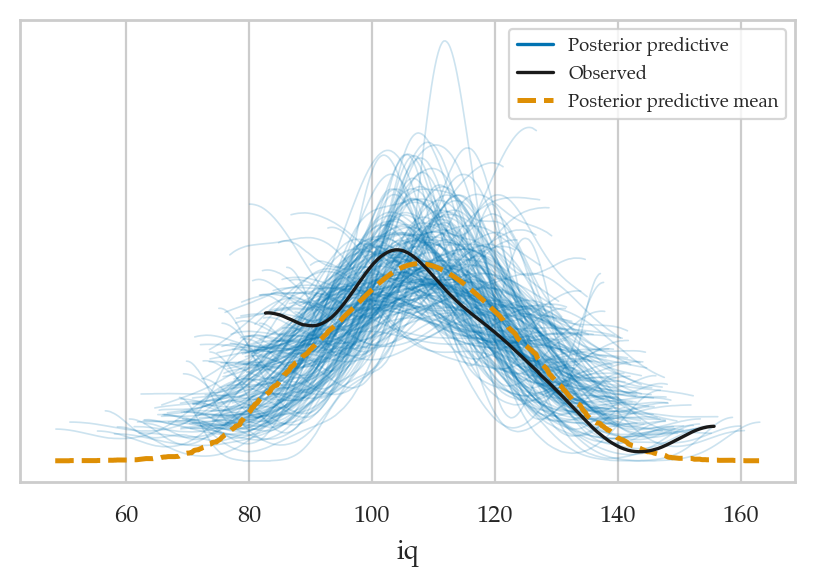

In [88]:
# Randomly sample 200 from all available posterior mean
# draws_subset = np.random.choice(idata2["posterior"]["draw"].values, 50, replace=False)
draws_subset = np.random.choice(2000, 50, replace=False)
idata2_rep = idata2.sel(draw=draws_subset)
mod2.predict(idata2_rep, kind="response")
az.plot_ppc(idata2_rep, group="posterior")

### Fitting model to synthetic data

In [89]:
np.random.seed(46)
from scipy.stats import norm
fakeiqs = norm(loc=110, scale=15).rvs(30)
fakeiqs = pd.DataFrame({"iq":fakeiqs})
fakeiqs["iq"].mean()

109.7132680142492

In [90]:
#######################################################
mod2f = bmb.Model(formula="iq ~ 1", family="gaussian",
                  priors=priors2, data=fakeiqs)
mod2f.set_alias({"Intercept": "M"})
idata2f = mod2f.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [91]:
az.summary(idata2f, kind="stats")

,mean,sd,hdi_3%,hdi_97%
M,109.65,2.736,104.645,114.719


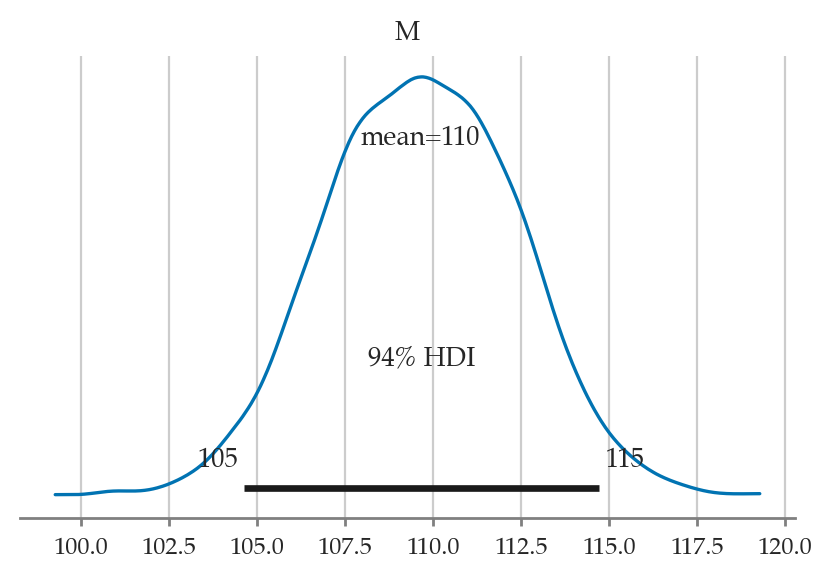

In [92]:
az.plot_posterior(idata2f);

### Sensitivity analysis

In [93]:
# TODO: reproduce sensitivity analysis from Secion 5.1

### Iterative model building

## Discussion

### Other types of priors

#### Conjugate priors

#### Uninformative priors

### Software for Bayesian inference

### Computational cost

### Reporting Bayesian results

## Model predictions (BONUS TOPIC)

### Coin toss predictions

Let's generate some observations form the posterior predictive distribution.

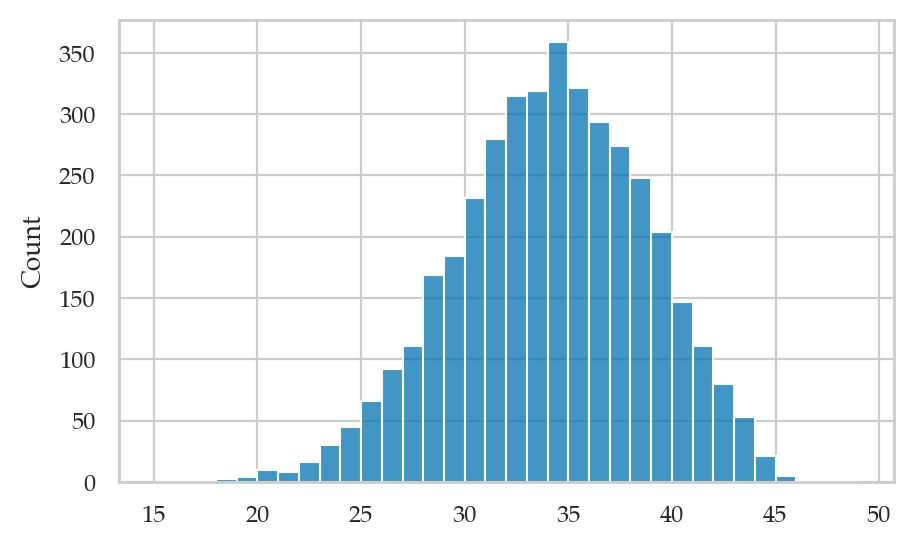

In [94]:
idata1_pred = idata1.copy()
# MAYBE: alt notation _rep instead of _pred ?
mod1.predict(idata1_pred, kind="response")
ctosses_pred = az.extract(idata1_pred,
                          group="posterior_predictive",
                          var_names=["ctoss"]).values
numheads_pred = ctosses_pred.sum(axis=0)

sns.histplot(x=numheads_pred, bins=range(15,50));

### IQ predictions

In [95]:
## Can't use Bambi predict because of issue
## https://github.com/bambinos/bambi/issues/850
# idata2_pred = mod2.predict(idata2, kind="response", inplace=False)
# preds2 = az.extract(idata2_pred, group="posterior", var_names=["mu"]).values.flatten()

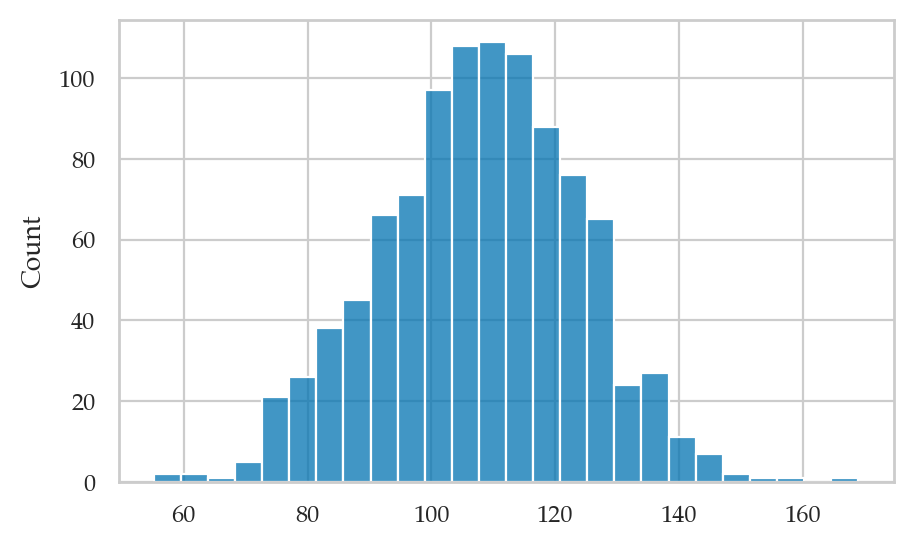

In [96]:
from scipy.stats import norm

sigma = 15  # known population standard deviation

iq_preds = []
np.random.seed(42)
for i in range(1000):
    mu_post = np.random.choice(postM)
    iq_pred = norm(loc=mu_post, scale=sigma).rvs(1)[0]
    iq_preds.append(iq_pred)

sns.histplot(x=iq_preds);

## Exercises

TODO: repeat exercises form Sec 5.1 using Bambi and ArviZ

### Exercise A
Reproduce the analysis of the IQ scores data from Example 2, but this time use a model with Bambi default priors.

a) Plot the priors using `plot_priors`.  
b) Compute the posterior mean, std, and a 90% hdi.  
c) Compare your result in (b) to the results we obtained from Example 2.

Sampling: [M, sigma]


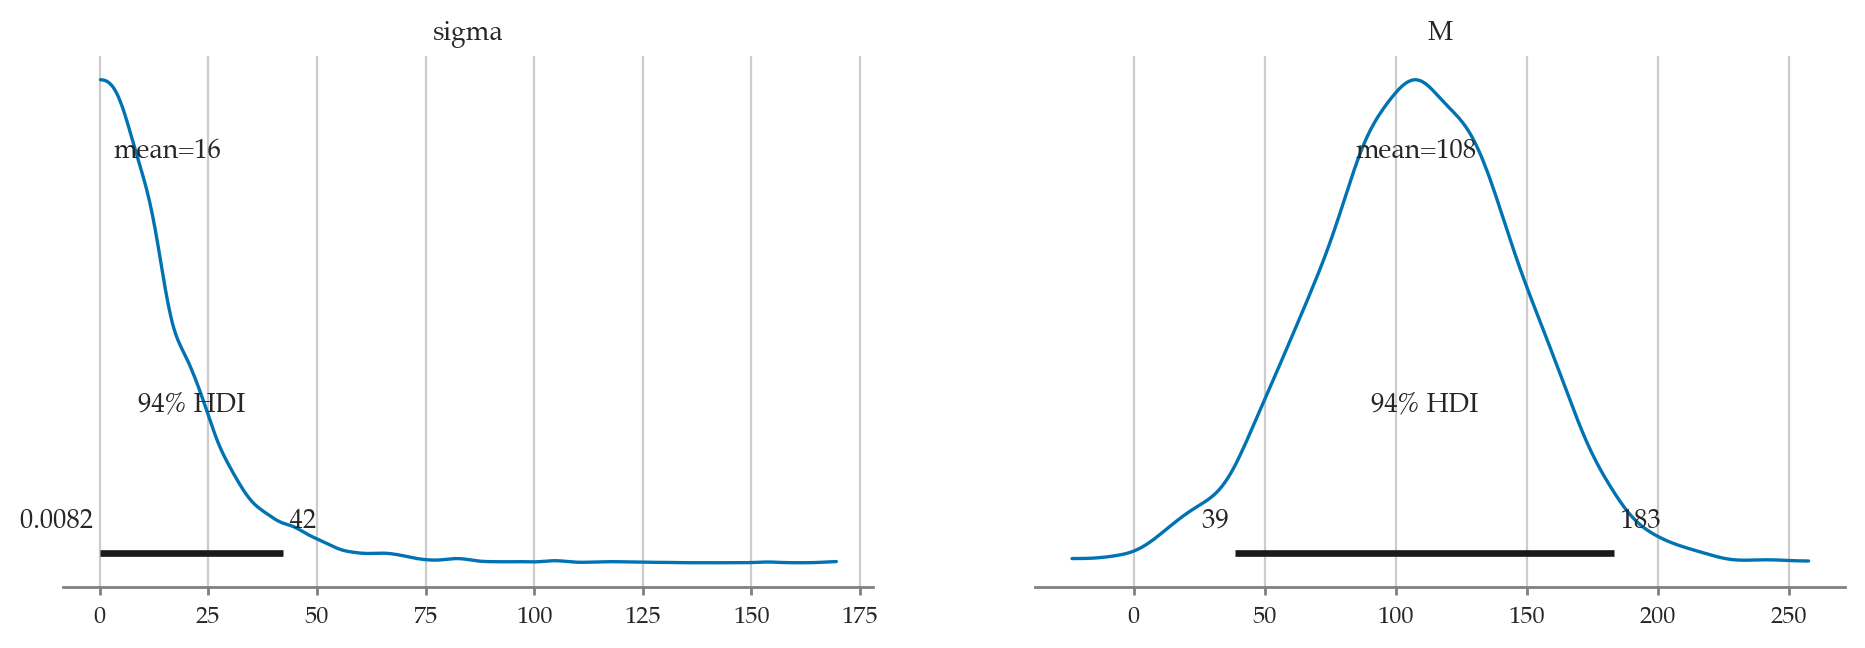

In [97]:
mod2d = bmb.Model("iq ~ 1", family="gaussian", data=iqs)
mod2d.set_alias({"Intercept": "M"})
mod2d.build()
mod2d.plot_priors();

In [98]:
idata2d = mod2d.fit(draws=2000, random_seed=42)
az.summary(idata2d, var_names="M", kind="stats", hdi_prob=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, M]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_5%,hdi_95%
M,107.828,3.05,103.0,112.908


In [99]:
az.summary(idata2, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
M,107.727,2.715,103.253,112.128


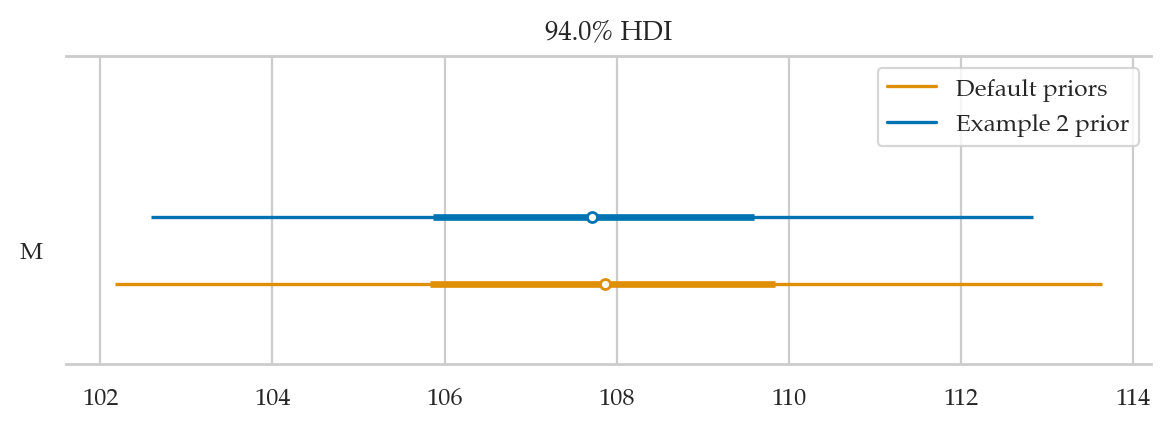

In [100]:
az.plot_forest(data=[idata2, idata2d],
               model_names=["Example 2 prior", "Default priors"],
               var_names="M", combined=True, figsize=(7,2));

### Exercise B

Repeat the analysis in Example 2,
but this time use the exponential prior $\text{Expon}(\lambda=0.1)$
on the parameter `sigma`. Calculate:

 a) Plot the priors using `plot_priors`.  
 b) Compute posterior mean of M and sigma.  
 c) Compute the posterior median of M and sigma.  
 d) Compute 90% credible interval for M and sigma.

<!-- for other options, see https://chatgpt.com/c/67337d93-dd70-8005-b592-2ffc3a3c17cc -->

In [101]:
import bambi as bmb
priors2e = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    "sigma": bmb.Prior("Exponential", lam=0.1),
}

mod2e = bmb.Model(formula="iq ~ 1",
                  family="gaussian",
                  link="identity",
                  priors=priors2e,
                  data=iqs)
mod2e.set_alias({"Intercept": "M"})

Sampling: [M, sigma]


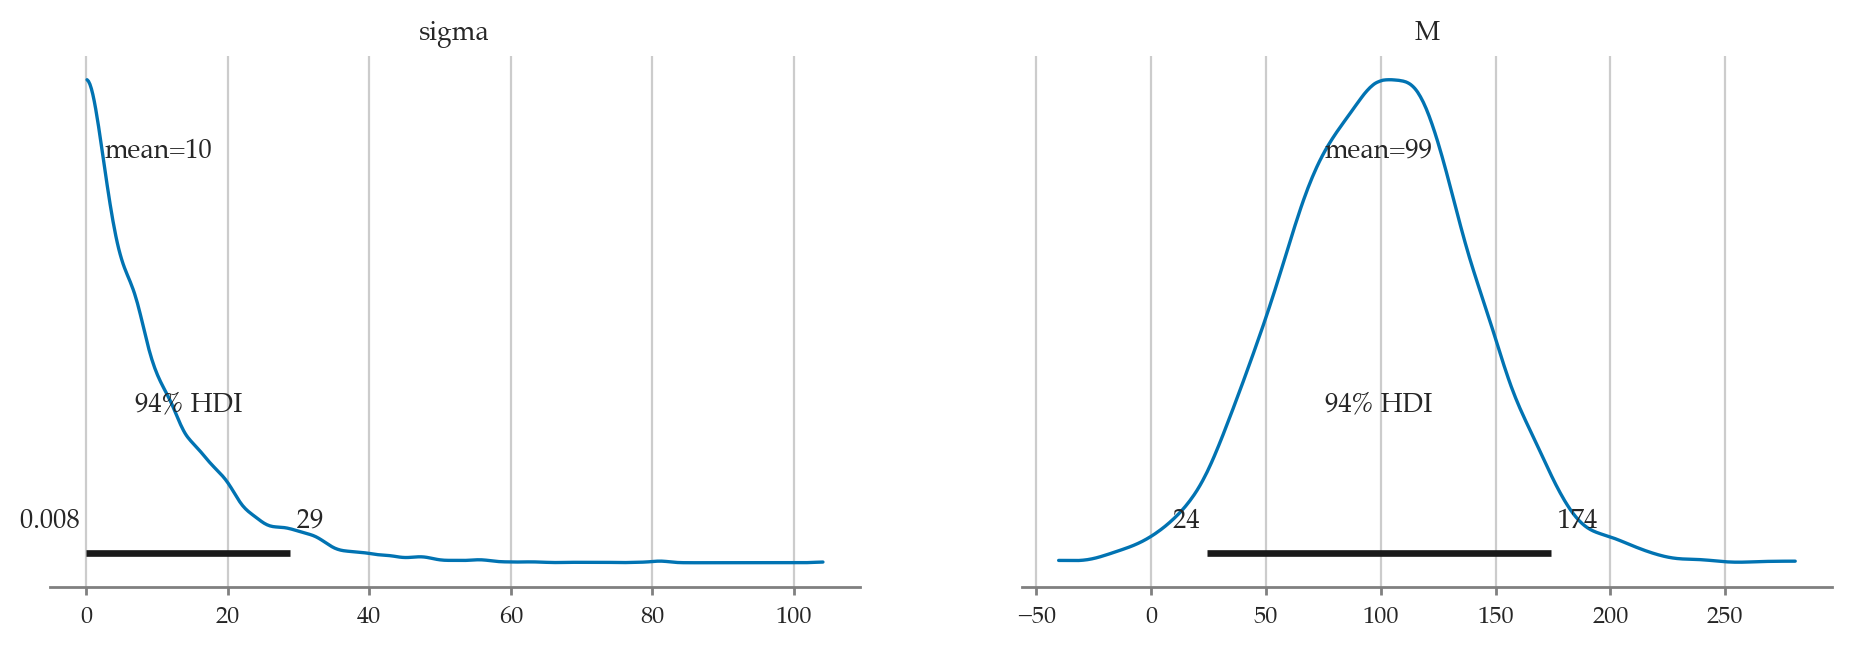

In [102]:
mod2e.build()
mod2e.plot_priors();

In [103]:
# idata2e = mod2e.fit(random_seed=42)
# az.plot_posterior(idata2e)

In [104]:
# JOINT PLOT
# M_samples = idata2e.posterior['M'].values.flatten()
# sigma_samples = idata2e.posterior['sigma'].values.flatten()
# sns.kdeplot(x=M_samples, y=sigma_samples, fill=True)
# plt.xlabel('M')
# plt.ylabel('Sigma')
# plt.title('Density Plot of Mean vs Sigma')

### Exercise C

## Links

TODO